In [10]:
# Install packages
install.packages(c("readxl", "ggplot2", "signal", "seismicRoll", "lubridate", "data.table", "oce"))

# Load libraries
library(readxl)      # For reading Excel files
library(ggplot2)     # For plotting
library(signal)      # For filtering (bandpass, etc.)
library(seismicRoll) # For STA/LTA algorithm
library(lubridate)   # For datetime handling
library(data.table)  # For efficient data manipulation
library(oce)         # For spectrograms

# Load the Excel file
moon_quakes <- read_excel("final.xlsx", sheet = "MoonQuake")
setDT(moon_quakes)  # Convert to data.table for faster processing

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [11]:
# View the first few rows
head(moon_quakes)


File Name,Mean Velocity,Standard Deviation,Max Velocity,Min Velocity,Range Velocity,Median Velocity,RMS Velocity,Energy,Impulse Factor,Velocity Derivative Mean,Velocity Derivative Std,Mean Velocity Around Arrival,Max Velocity Around Arrival,Arrival Time,Max STA/LTA,mq_type
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
xa.s12.00.mhz.1970-01-19HR00_evid00002,-8.443134e-13,3.530056e-10,7.874026e-09,-8.185283e-09,1.605931e-08,-1.633815e-17,3.530066e-10,7.133071e-14,0.05000044,1.953538e-19,1.617267e-09,-2.976370e-11,1.509733e-09,73500,10.20039,impact_mq
xa.s12.00.mhz.1970-03-25HR00_evid00003,-1.939339e-12,3.865137e-10,4.707866e-09,-4.603228e-09,9.311095e-09,1.764188e-12,3.865185e-10,8.551625e-14,0.05000079,2.327948e-20,1.300470e-09,2.869342e-11,8.028672e-10,73500,10.24435,impact_mq
xa.s12.00.mhz.1970-03-26HR00_evid00004,-2.980386e-13,3.219582e-10,5.969005e-09,-6.144452e-09,1.211346e-08,3.116433e-16,3.219583e-10,5.933450e-14,0.05000079,1.108431e-19,1.377912e-09,-7.111081e-11,3.978438e-09,73500,10.16017,impact_mq
xa.s12.00.mhz.1970-04-25HR00_evid00006,-1.547089e-13,3.383782e-10,6.853803e-09,-6.155705e-09,1.300951e-08,3.515417e-14,3.383782e-10,6.554142e-14,0.05000044,-7.894813e-20,1.571516e-09,-3.392656e-12,4.175311e-10,73500,10.08300,impact_mq
xa.s12.00.mhz.1970-04-26HR00_evid00007,-6.921802e-13,3.009879e-10,5.491012e-09,-4.475551e-09,9.966563e-09,-3.369827e-13,3.009887e-10,5.185712e-14,0.05000079,2.122734e-20,1.254288e-09,-1.387347e-11,4.500003e-10,73500,10.32268,deep_mq
xa.s12.00.mhz.1970-06-15HR00_evid00008,-7.786379e-13,5.558376e-10,1.926139e-08,-1.909494e-08,3.835633e-08,2.333255e-17,5.558381e-10,1.768520e-13,0.05000017,5.423587e-21,2.718284e-09,7.418675e-12,5.616385e-10,73500,20.70292,impact_mq


In [12]:
colnames(moon_quakes)
colnames(moon_quakes) <- gsub(" ", "_", colnames(moon_quakes))
colnames(moon_quakes) <- gsub("/", "_", colnames(moon_quakes))
colnames(moon_quakes)

[1] "File Name"                    "Mean Velocity"               
 [3] "Standard Deviation"           "Max Velocity"                
 [5] "Min Velocity"                 "Range Velocity"              
 [7] "Median Velocity"              "RMS Velocity"                
 [9] "Energy"                       "Impulse Factor"              
[11] "Velocity Derivative Mean"     "Velocity Derivative Std"     
[13] "Mean Velocity Around Arrival" "Max Velocity Around Arrival" 
[15] "Arrival Time"                 "Max STA/LTA"                 
[17] "mq_type"

[1] "File_Name"                    "Mean_Velocity"               
 [3] "Standard_Deviation"           "Max_Velocity"                
 [5] "Min_Velocity"                 "Range_Velocity"              
 [7] "Median_Velocity"              "RMS_Velocity"                
 [9] "Energy"                       "Impulse_Factor"              
[11] "Velocity_Derivative_Mean"     "Velocity_Derivative_Std"     
[13] "Mean_Velocity_Around_Arrival" "Max_Velocity_Around_Arrival" 
[15] "Arrival_Time"                 "Max_STA_LTA"                 
[17] "mq_type"

In [13]:
# Summary statistics
summary(moon_quakes[, .(Mean_Velocity, Max_Velocity, Arrival_Time, Max_STA_LTA)])

 Mean_Velocity         Max_Velocity        Arrival_Time    Max_STA_LTA       
 Min.   :-7.345e-12   Min.   :2.040e-09   Min.   :73500   Min.   :    7.444  
 1st Qu.:-8.930e-13   1st Qu.:3.435e-09   1st Qu.:73500   1st Qu.:   10.215  
 Median :-4.022e-13   Median :5.899e-09   Median :73500   Median :   10.375  
 Mean   :-7.537e-13   Mean   :1.556e-08   Mean   :73500   Mean   :  795.525  
 3rd Qu.:-2.121e-14   3rd Qu.:1.293e-08   3rd Qu.:73500   3rd Qu.:   10.508  
 Max.   : 1.168e-12   Max.   :1.473e-07   Max.   :73500   Max.   :57360.347  

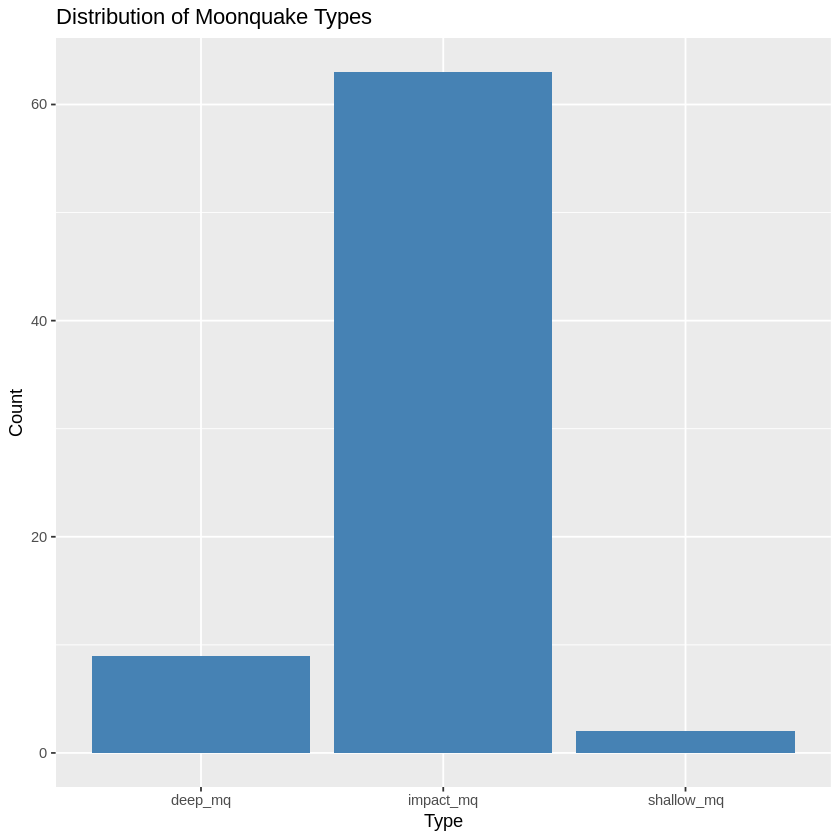

In [14]:
# Plot distribution of moonquake types
ggplot(moon_quakes, aes(x = mq_type)) +
  geom_bar(fill = "steelblue") +
  labs(title = "Distribution of Moonquake Types", x = "Type", y = "Count")

In [15]:
class(moon_quakes$Arrival_Time)  # Should be "numeric" or "POSIXct"

[1] "numeric"

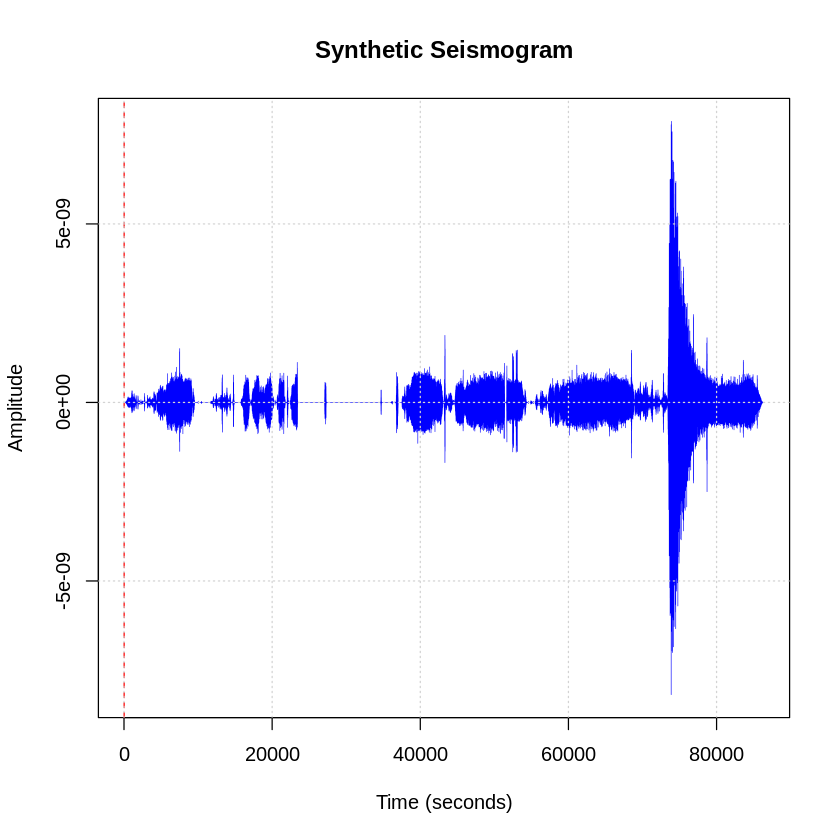

In [16]:
data <- read.csv("xa.s12.00.mhz.1970-01-19HR00_evid00002.csv")

# Create synthetic seismogram data
time <- seq(0, 60, by = 0.01)  # 60 seconds with 0.01s sampling interval
set.seed(123)  # For reproducibility

# Create a synthetic seismic signal with noise
signal <- 5 * sin(2 * pi * 1 * time) * exp(-0.05 * time)  # Decaying sine wave
noise <- rnorm(length(time), sd = 0.5)  # Gaussian noise
seismic_data <- signal + noise

# Add a synthetic seismic event at t=20s
event_time <- 20
event <- 10 * dnorm(time, mean = event_time, sd = 0.2)  # Gaussian pulse
seismic_data <- seismic_data + event

# Plot the seismogram
plot(data$time_rel.sec., data$velocity.m.s.,
     type = "l",  # Line plot
     col = "blue",
     xlab = "Time (seconds)",
     ylab = "Amplitude",
     main = "Synthetic Seismogram",
     lwd = 0.5)  # Line width

# Add a red line to mark the event
abline(v = event_time, col = "red", lty = 2)

# Optional: Add grid lines
grid()

In [18]:
install.packages(c("shiny", "tidyverse", "seismicRoll", "lubridate", "plotly", "reticulate"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘crosstalk’, ‘RcppTOML’, ‘here’, ‘png’




In [19]:
library(shiny)
library(tidyverse)
library(seismicRoll)
library(plotly)

# Define UI
ui <- fluidPage(
  titlePanel("Seismic Event Detector"),
  sidebarLayout(
    sidebarPanel(
      fileInput("file", "Upload Seismic Data (CSV)"),
      sliderInput("sta_window", "STA Window (seconds):", 10, 300, 30),
      sliderInput("lta_window", "LTA Window (seconds):", 100, 1000, 300),
      numericInput("on_trigger", "Trigger On Threshold:", 3),
      numericInput("off_trigger", "Trigger Off Threshold:", 1.5),
      actionButton("detect", "Detect Events")
    ),
    mainPanel(
      plotlyOutput("seismic_plot"),
      tableOutput("events_table")
    )
  )
)

# Define server logic
server <- function(input, output) {

  # Load data
  data <- reactive({
    req(input$file)
    read_csv(input$file$datapath)
  })

  # Detect events using STA/LTA
  events <- eventReactive(input$detect, {
    df <- data()
    df$sta_lta_ratio <- seismicRoll::roll_stalta(
      df$velocity,
      n_sta = input$sta_window,
      n_lta = input$lta_window
    )
    # Find peaks (simple threshold method)
    df$is_event <- df$sta_lta_ratio > input$on_trigger
    df
  })

  # Plot seismic data with detected events
  output$seismic_plot <- renderPlotly({
    df <- events()
    plot_ly(df, x = ~time_rel(sec), y = ~velocity(m/s), type = 'scatter', mode = 'lines') %>%
      add_markers(
        data = filter(df, is_event),
        x = ~time_rel(sec),
        y = ~velocity(m/s),
        marker = list(color = 'red'),
        name = 'Detected Event'
      )
  })

  # Show detected events table
  output$events_table <- renderTable({
    df <- events()
    df %>%
      filter(is_event) %>%
      select(time_rel(sec), sta_lta_ratio) %>%
      head(10)
  })
}

# Run the app
shinyApp(ui, server)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr   1.1.4     ✔ stringr 1.5.1
✔ forcats 1.0.0     ✔ tibble  3.2.1
✔ purrr   1.0.4     ✔ tidyr   1.3.1
✔ readr   2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()      masks data.table::between()
✖ dplyr::filter()       masks signal::filter(), stats::filter()
✖ dplyr::first()        masks data.table::first()
✖ data.table::hour()    masks lubridate::hour()
✖ data.table::isoweek() masks lubridate::isoweek()
✖ dplyr::lag()          masks stats::lag()
✖ dplyr::last()         masks data.table::last()
✖ data.table::mday()    masks lubridate::mday()
✖ data.table::minute()  masks lubridate::minute()
✖ data.table::month()   masks lubridate::month()
✖ data.table::quarter() masks lubridate::quarter()
✖ data.table::second()  masks lubridate::second()
✖ purrr::transpose()    masks data.table::transpose()
✖ data.table::wday()    masks lubridate::wday()
✖ 

In [21]:
install.packages("seewave")
library(signal)
library(seewave)
library(tuneR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘tuneR’



Attaching package: ‘seewave’


The following object is masked from ‘package:plotly’:

    export


The following object is masked from ‘package:readr’:

    spec


The following object is masked from ‘package:oce’:

    rescale


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:signal’:

    unwrap




In [22]:

# ----- Read your CSV -----
data_cat <- read.csv("/content/xa.s12.00.mhz.1970-01-19HR00_evid00002.csv")

In [23]:
colnames(data_cat)

[1] "time_abs..Y..m..dT.H..M..S..f." "time_rel.sec."                 
[3] "velocity.m.s."

In [25]:
# Suppose your current colnames are
colnames(data_cat) <- gsub("[^a-zA-Z0-9]", "_", colnames(data_cat))


In [26]:
colnames(data_cat)

[1] "time_abs__Y__m__dT_H__M__S__f_" "time_rel_sec_"                 
[3] "velocity_m_s_"

In [27]:
time_data <- data_cat$time_rel_sec_  # <-- Time column (input here)
velocity_data <- data_cat$velocity_m_s_

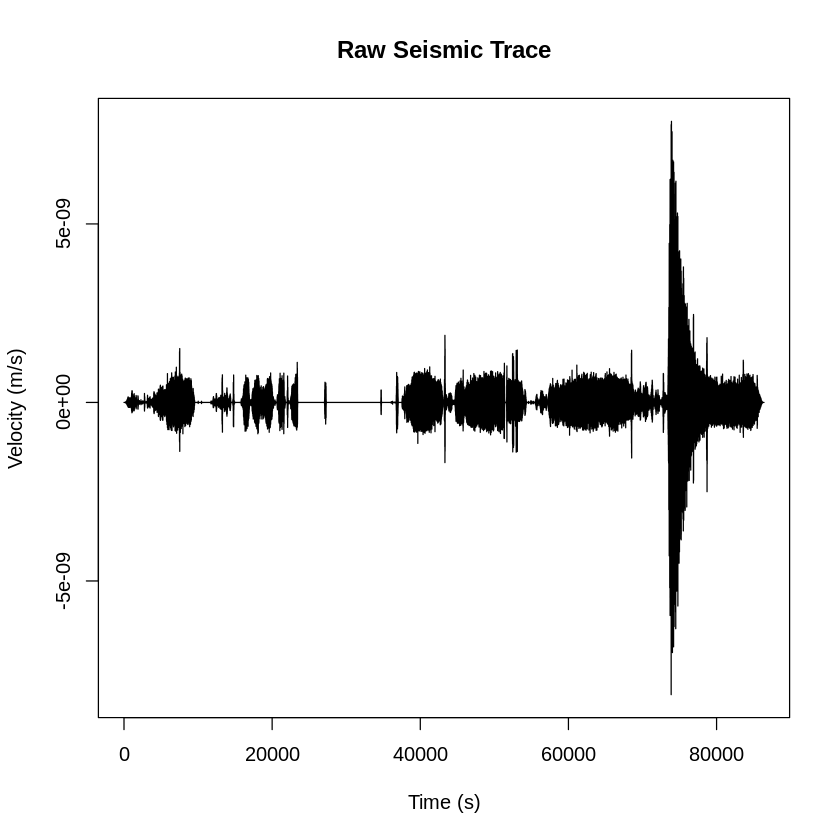

In [28]:
# Install necessary libraries if you don't have them
# install.packages("signal")
# install.packages("seewave")
# install.packages("tuneR")



# ----- Select your columns -----
# This is where you input your time data column and velocity column!
  # <-- Signal amplitude column (input here)

# ----- Plot the raw signal -----
plot(time_data, velocity_data, type = "l",
     xlab = "Time (s)", ylab = "Velocity (m/s)",
     main = "Raw Seismic Trace")




In [30]:
# ----- Calculate and plot the spectrogram -----
# We need to create a Wave object (seewave expects audio-like input)
# Let's assume sampling rate ~6.625 Hz (as from your miniseed header)
sampling_rate <- 6.625

# Convert signal into a Wave object (normalize it first)
velocity_wave <- Wave(left = as.numeric(velocity_data), samp.rate = sampling_rate, bit = 16)


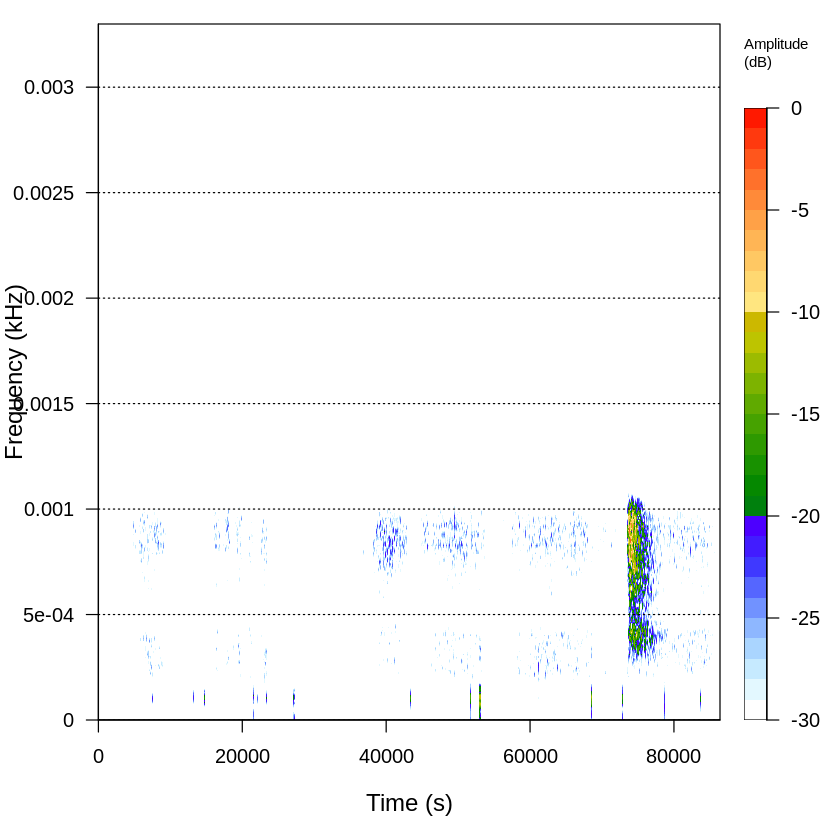

In [33]:

# Plot the spectrogram
spectro(velocity_wave, f = sampling_rate, wl = 512, ovlp = 75)

# 'flim' sets frequency limits on y-axis, adjust as needed